# **Introduction to Machine Learning Chapter 5.2**
# **Hand-written digits recognition using neural network**
---

## inport libraries

In [1]:
import numpy as np                  # for scientific computing (e.g. culclations with array)
import pandas as pd                 # for data manipulation and analysis
import matplotlib.pyplot as plt     # for visualization

np.set_printoptions(suppress=True)  # If True, always print floating point numbers using fixed point notation. If False, then scientific notation is used.
np.set_printoptions(precision=3, floatmode='fixed')

### Class Definition

In [2]:
class Linear:
    def __init__(self, w, b):
        self.w = w # weights
        self.b = b # biases
        self.x = None
        self.dw = None # gradient of w
        self.db = None # gradient of b

    def forward(self, x):
        self.x = x
        p = np.dot(x, self.w) + self.b    # Affine mapping
        return p

    def backward(self, dL0):
        dL = np.dot(dL0, self.w.T)        # dL/dx
        self.dw = np.dot(self.x.T, dL0)   # dL/dw
        self.db = np.sum(dL0, axis=0)     # dL/db
        return dL

    def get_params(self):
        return [self.w, self.b]

    def get_grads(self):
        return [self.dw, self.db]

class Sigmoid:
    def __init__(self):
        self.y = None

    def forward(self, x):
        y = 1 / (1 + np.exp(-x))  # Sigmoid function
        self.y = y
        return y

    def backward(self, dL0):
        dL = dL0 * self.y * (1.0 - self.y)  #dL/dp
        return dL

    def get_params(self):
        return []

    def get_grads(self):
        return []

class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    out = x.copy()
    self.mask = (x <= 0)    # Save information of elements that were less than or equal to 0 as "mask".
    out[self.mask] = 0      #replace elements that were less than or equal to 0 with 0.
    return out

  def backward(self, dout):
    dout[self.mask] = 0 #Replace elements that were less than or equal to 0 during forward propagation with 0.
    dx = dout
    return dx

class MSE:
    def __init__(self):
        self.z = None
        self.t = None

    def forward(self, z, t):
        self.z = z
        self.t = t
        row, col = z.shape # row:data_num, col:input dimension
        loss = np.sum((z-t) ** 2) / row
        return loss

    def backward(self):
        dL = self.z - self.t    #dL/dz
        return dL

class SoftmaxWithCrossEntropy:
    def __init__(self):
        self.loss = None
        self.y = None # output of softmax
        self.t = None # labels

    def forward(self, x, t):
        self.t = t
        self.y = self.softmax(x)
        self.loss = self.cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        input_size = self.t.shape[0]
        dx = (self.y - self.t) / input_size
        return dx

    def softmax(self, x):
        max_x = np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(x - max_x)  # overflow protection
        y = exp_x / np.sum(exp_x, axis=-1, keepdims=True)
        return y

    def cross_entropy_error(self, y, t):
        delta = 1e-7
        return -np.sum(t * np.log(y + delta))

# optimizer
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, layers):
        for layer in layers.values():
            for (param, grad) in zip(layer.get_params(), layer.get_grads()):
                param -= self.learning_rate * grad # Gradient descent

# Calculate accuracy using predictions and targets
def accuracy(y_pred, t):
  acc = np.sum(y_pred == t) / np.float32(t.shape[0])
  return acc

## Download MNIST dataset using Keras

In [3]:
from keras.datasets import mnist

#load MNIST dataset
(img_train, t_train), (img_test, t_test) = mnist.load_data()

print(img_train.shape)
print(t_train.shape)
print(img_test.shape)
print(t_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Reshaping and normalization

In [4]:
#reshaping input data. row * col * color = 28 * 28 * 1 (grayscale)
x_train = img_train.reshape(-1, 28 * 28 * 1) / 255     # Min-Max normalization
x_test = img_test.reshape(-1, 28 * 28 * 1) / 255       # Min-Max normalization

#one-hot encoding, out_size = 10
t_train_onehot = np.identity(10)[t_train]
t_test_onehot = np.identity(10)[t_test]

print(x_train.shape)
print(t_train_onehot.shape)
print(x_test.shape)
print(t_test_onehot.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


## Visualization

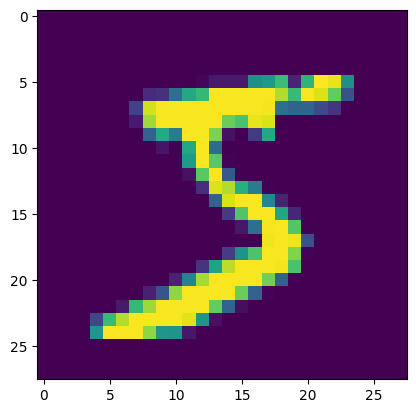

5


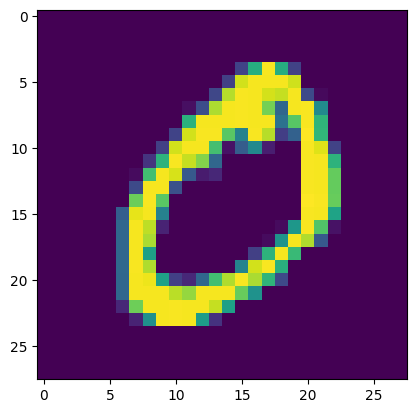

0


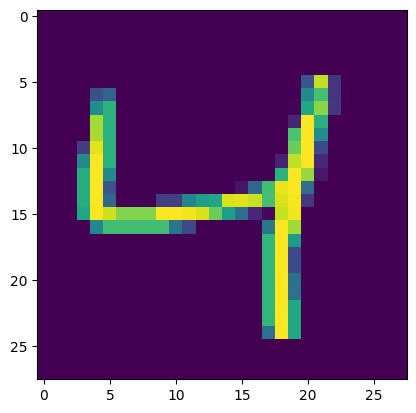

4


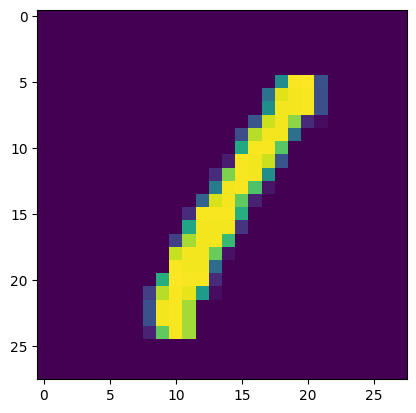

1


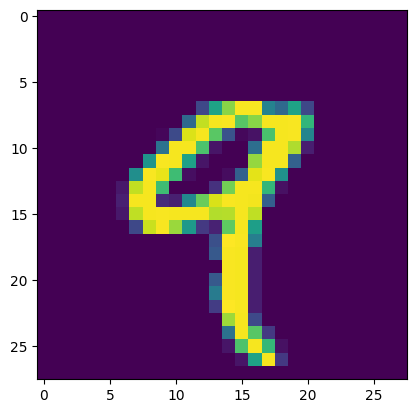

9


In [5]:
import matplotlib.pyplot as plt

ids = [0, 1, 2, 3, 4]  #for example

for i in ids:
  example = x_train[i].reshape(28, 28)
  plt.imshow(example)
  plt.show()

  print(t_train[i])

## class definition

## Define neural network model with 2 linear layer

In [6]:
from collections import OrderedDict

class Model4:
    def __init__(self, input_size, hidden_size, output_size):
        #initialize weights and biases
        W1 = np.random.randn(input_size, hidden_size)  #initialize weights with random value
        b1 = np.zeros(hidden_size)  #initialize biases with 0
        W2 = np.random.randn(hidden_size, output_size)  #initialize weights with random value
        b2 = np.zeros(output_size)  #initialize biases with 0

        #neural network model definition
        self.layers = OrderedDict()
        self.layers['linear1'] = Linear(W1, b1)     # Linear layer
        self.layers['sigmoid1'] = Sigmoid()         # Sigmoid layer
        self.layers['linear2'] = Linear(W2, b2)     # Linear layer
        self.loss_layer = SoftmaxWithCrossEntropy() # Softmax with CrossEntropy layer

    def get_layers(self):
        return self.layers

    # forward calculation
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.loss_layer.forward(y, t)  # get Loss and return

    # backward calculation
    def backward(self):
        dL = self.loss_layer.backward() # Loss layer
        for layer in reversed(self.layers.values()):
            dL = layer.backward(dL)

## 🤔 **Exercise 5.2.1** Learning neural network

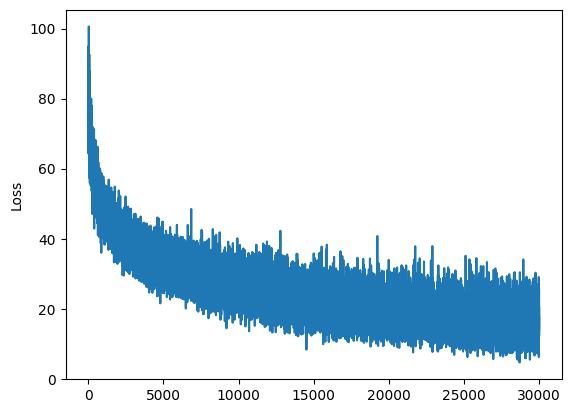

In [7]:
train_num = x_train.shape[0]
test_num = x_test.shape[0]

#model
input_size = x_train.shape[1]          # 784
output_size = t_train_onehot.shape[1]  # 10
hidden_size = 10                            # hyper parameter
net = Model4(input_size, hidden_size, output_size)
optimizer = SGD(learning_rate = 0.01)       # for update parameters

Epoch = 10 # the number of training
Minibatch_size = 20
Minibatch_num = int(train_num / Minibatch_size)
loss = []

#learning process
for i in range(Epoch):

    #Shuffled IDs for minibach
    idx = np.random.permutation(train_num)
    idx = np.reshape(idx, (-1, Minibatch_size))

    for i in range(Minibatch_num):
        #create minibatch datasets
        x = x_train[idx[i]]        # x is minibatch_size by 784 matrix
        t = t_train_onehot[idx[i]] # t is minibatch_size by 10 matrix

        l = net.loss(x, t)          #forward calculation
        net.backward()              # backward propagation
        optimizer.update(net.get_layers()) # update parameters
        loss.append(l)

# draw the loss graph
plt.plot(loss)
plt.ylabel("Loss")
plt.show()


## Prediction and evaluation using test data

In [8]:
# prediction (the output is the probability distribution)
y_train = net.predict(x_train)
y_test = net.predict(x_test)

# pred is the label of the output given the highest probability by the network
y_train_pred = np.argmax(y_train, axis=1)
y_test_pred = np.argmax(y_test, axis=1)

# evaluation
acc_train = accuracy(y_train_pred, t_train)
acc_test = accuracy(y_test_pred, t_test)
print("accuracy(train) = ", acc_train)
print("accuracy(test) = ", acc_test)

accuracy(train) =  0.7592333333333333
accuracy(test) =  0.7615


## Dispaly the confusion matrix

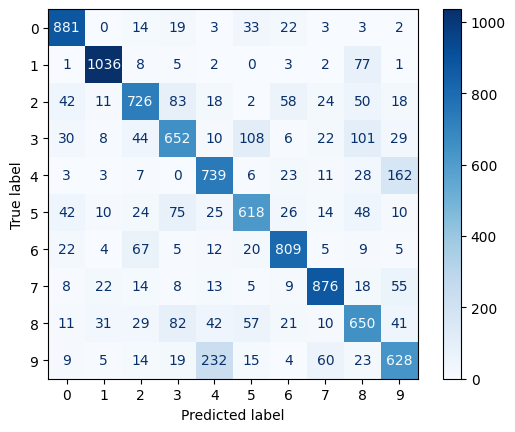

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = np.arange(0, 10, 1) # [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(y_pred=y_test_pred, y_true=t_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)

cmp.plot(cmap=plt.cm.Blues)

## Displaying misrecognized images

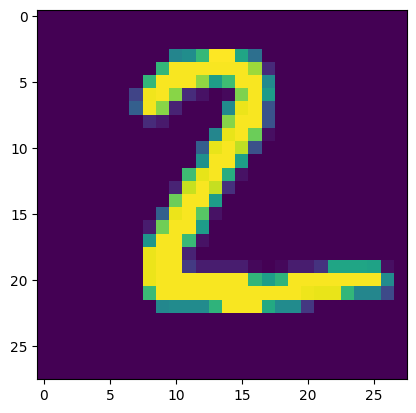

correct answer is  2
the prediction is  0


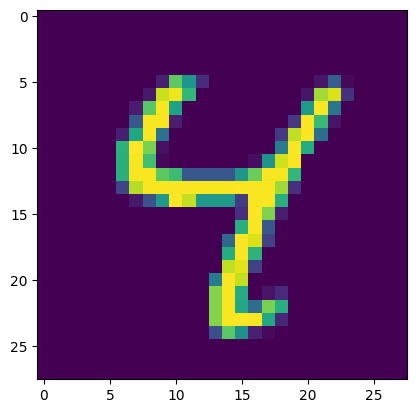

correct answer is  4
the prediction is  9


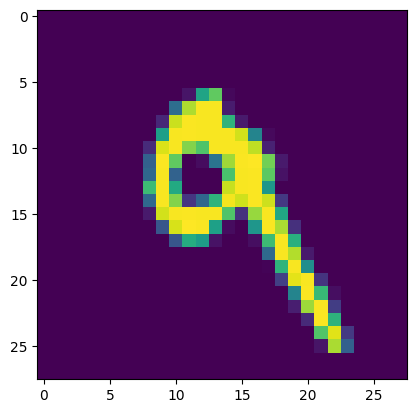

correct answer is  9
the prediction is  4


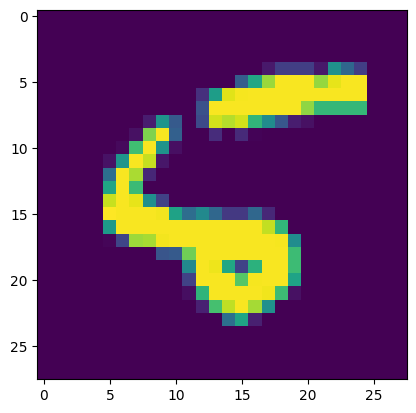

correct answer is  5
the prediction is  2


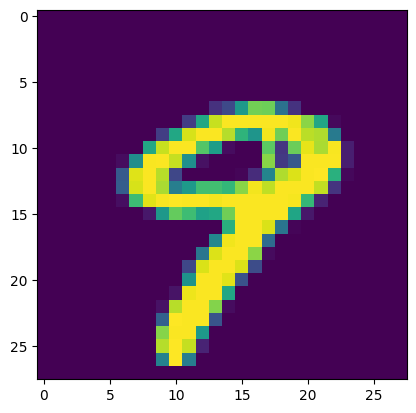

correct answer is  9
the prediction is  7


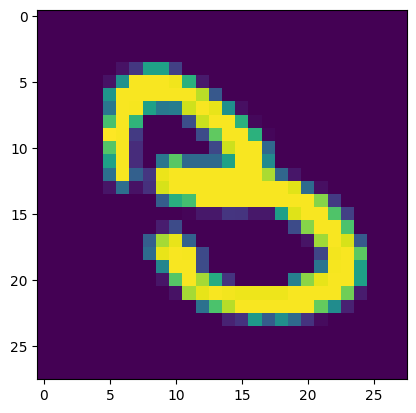

correct answer is  3
the prediction is  4


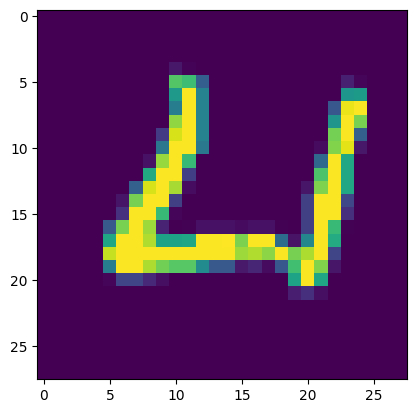

correct answer is  4
the prediction is  6


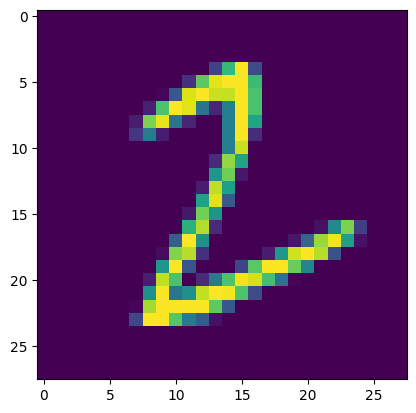

correct answer is  2
the prediction is  3


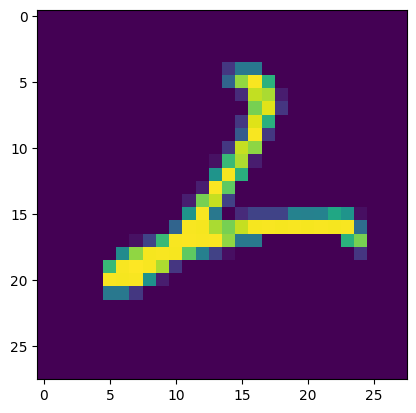

correct answer is  2
the prediction is  8


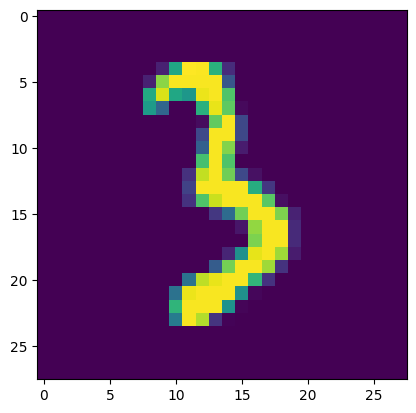

correct answer is  3
the prediction is  1


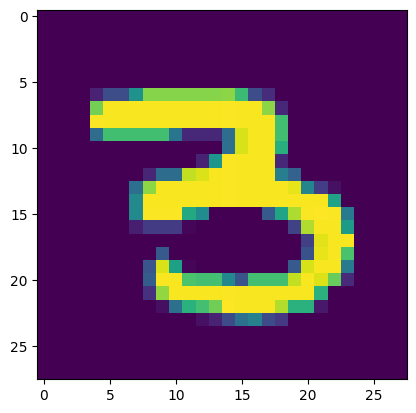

correct answer is  3
the prediction is  0


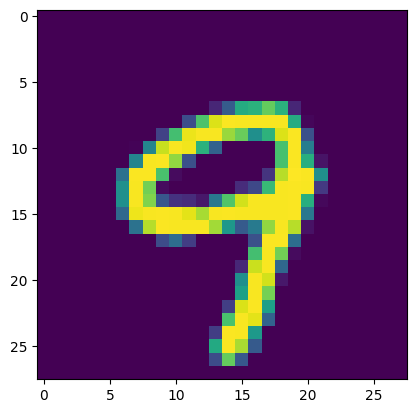

correct answer is  9
the prediction is  7


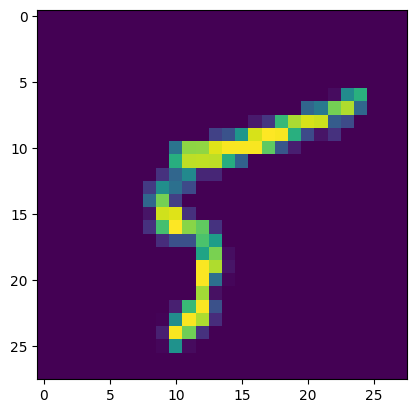

correct answer is  5
the prediction is  0


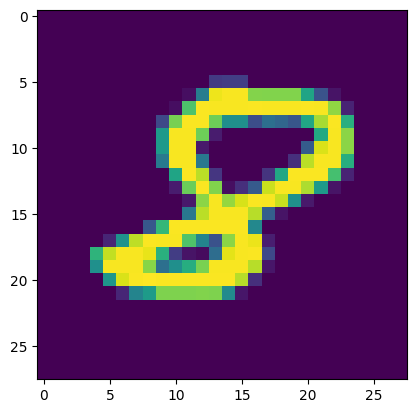

correct answer is  8
the prediction is  2


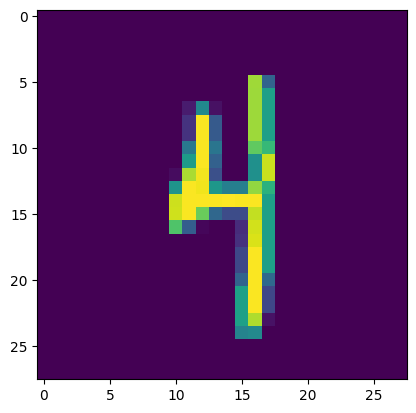

correct answer is  4
the prediction is  5


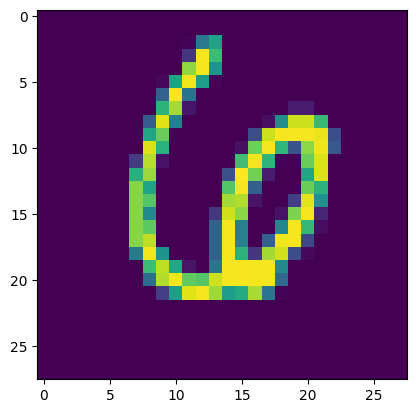

correct answer is  6
the prediction is  2


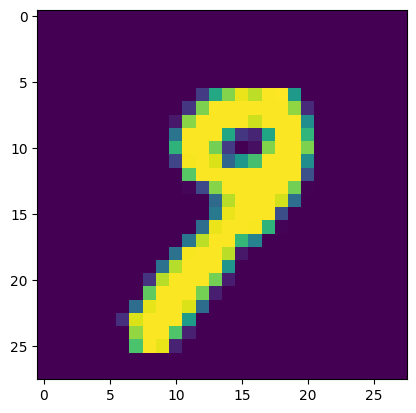

correct answer is  9
the prediction is  7


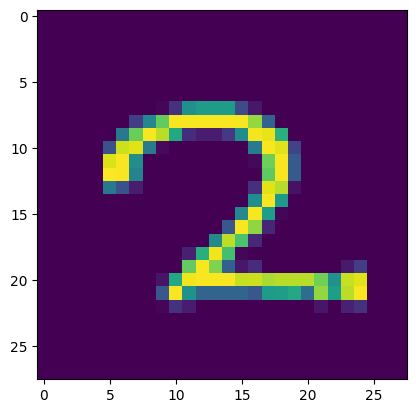

correct answer is  2
the prediction is  7


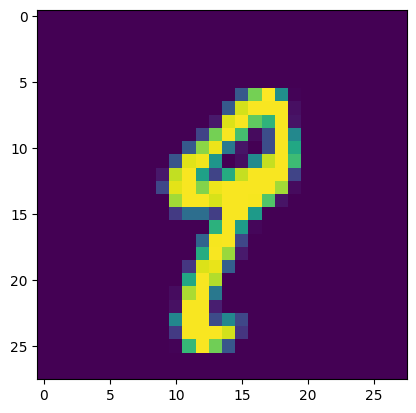

correct answer is  9
the prediction is  8


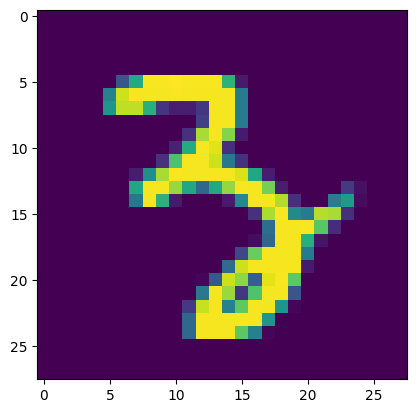

correct answer is  3
the prediction is  5


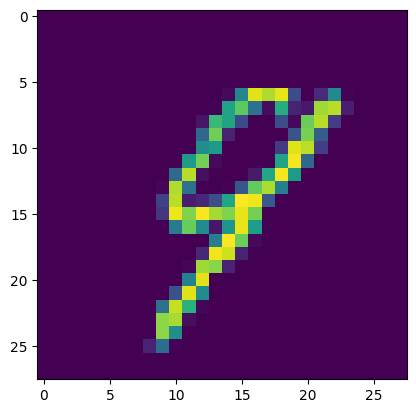

correct answer is  9
the prediction is  8


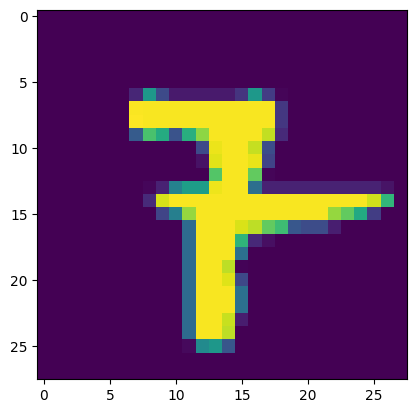

correct answer is  7
the prediction is  4


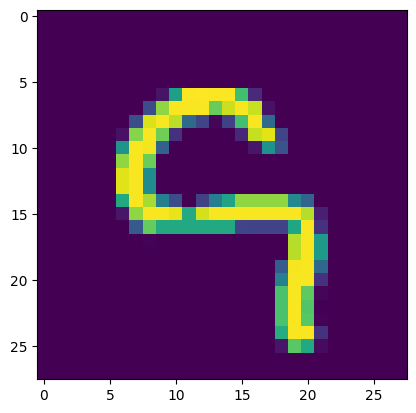

correct answer is  9
the prediction is  2


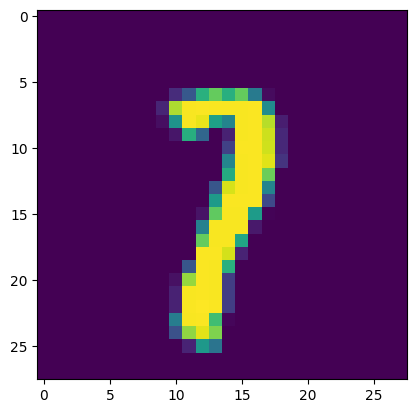

correct answer is  7
the prediction is  1


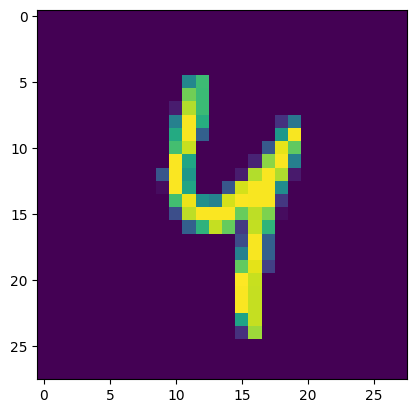

correct answer is  4
the prediction is  9


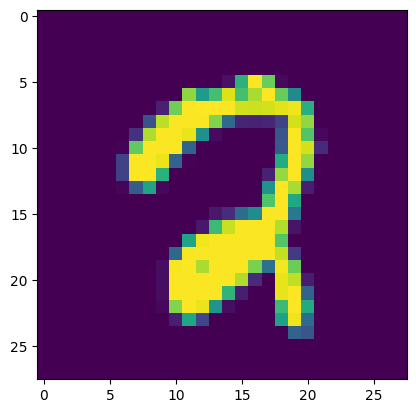

correct answer is  2
the prediction is  7


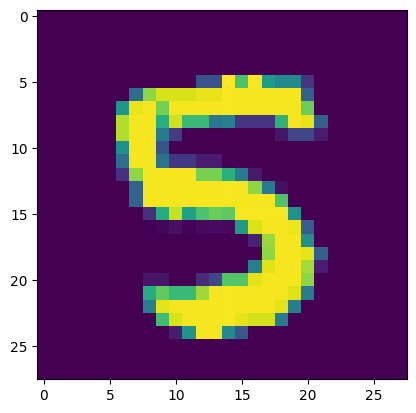

correct answer is  5
the prediction is  3


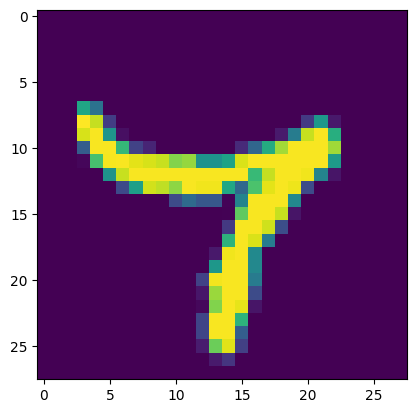

correct answer is  7
the prediction is  9


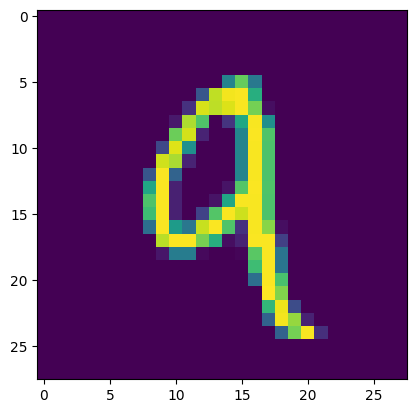

correct answer is  9
the prediction is  4


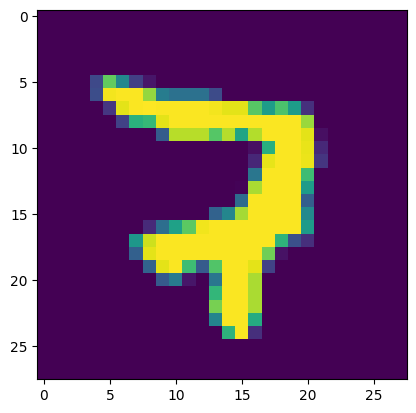

correct answer is  7
the prediction is  9


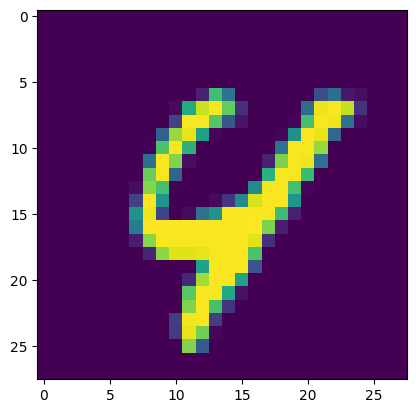

correct answer is  4
the prediction is  9


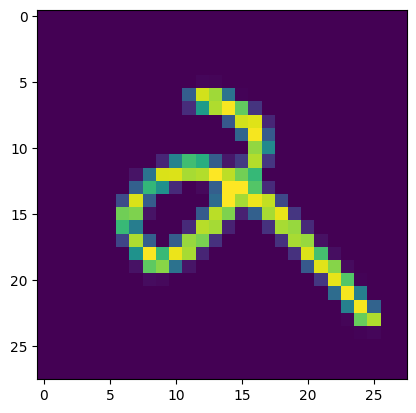

correct answer is  2
the prediction is  8


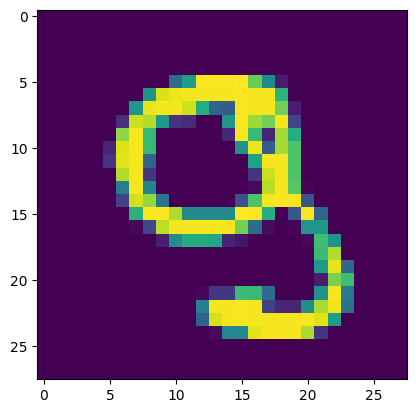

correct answer is  9
the prediction is  3


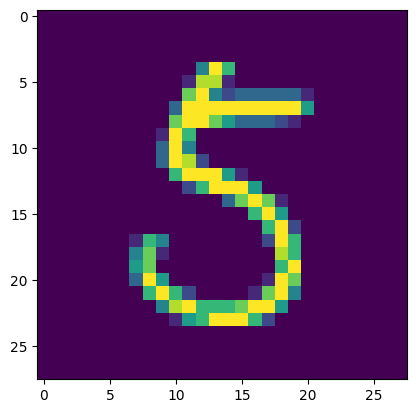

correct answer is  5
the prediction is  3


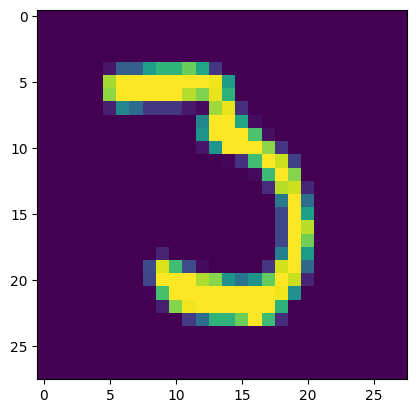

correct answer is  3
the prediction is  0


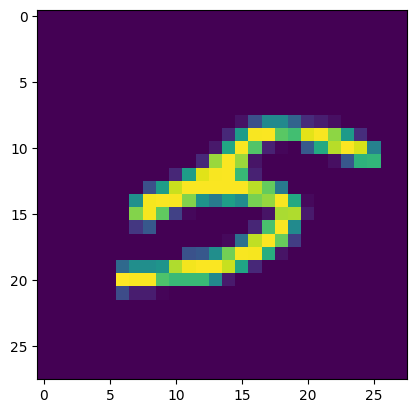

correct answer is  5
the prediction is  6


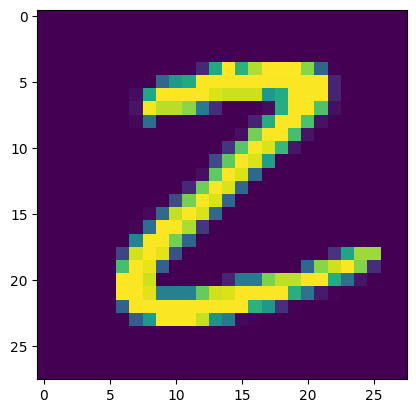

correct answer is  2
the prediction is  3


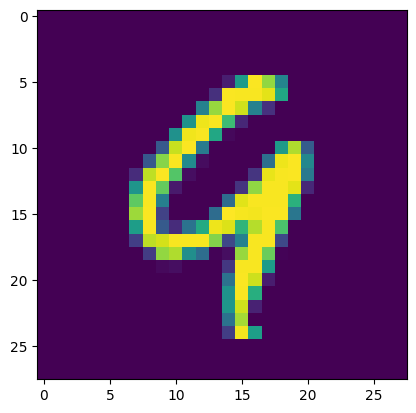

correct answer is  9
the prediction is  4


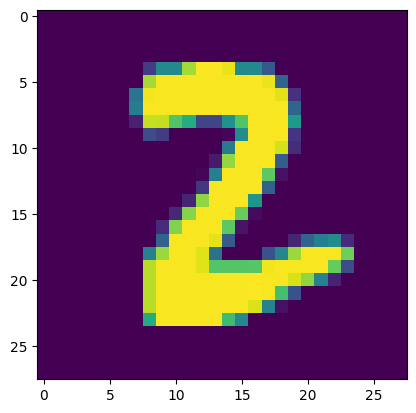

correct answer is  2
the prediction is  3


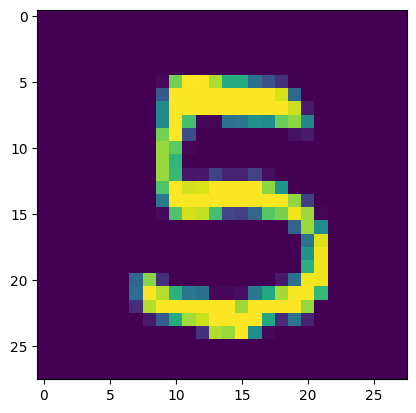

correct answer is  5
the prediction is  3


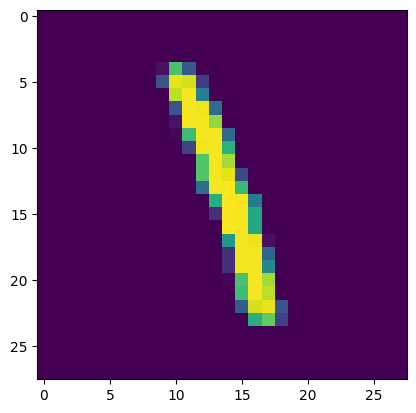

correct answer is  1
the prediction is  8


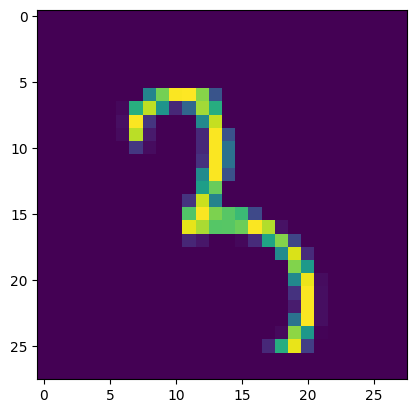

correct answer is  3
the prediction is  8


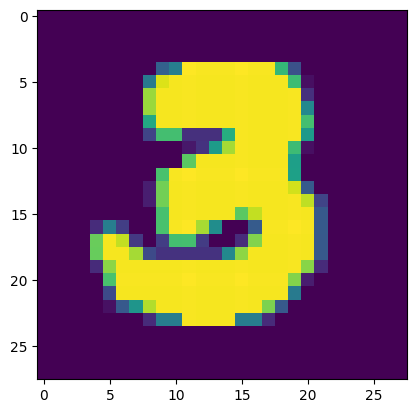

correct answer is  3
the prediction is  2


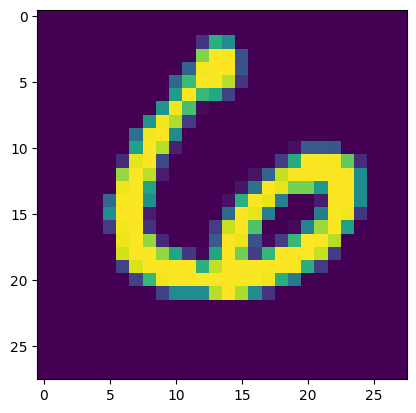

correct answer is  6
the prediction is  2


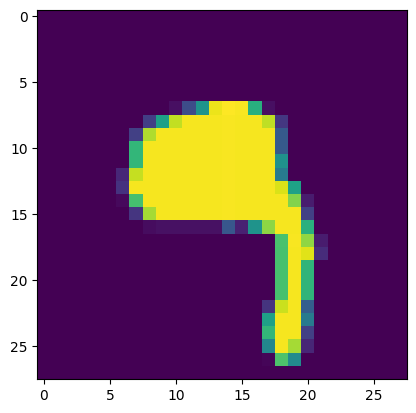

correct answer is  9
the prediction is  4


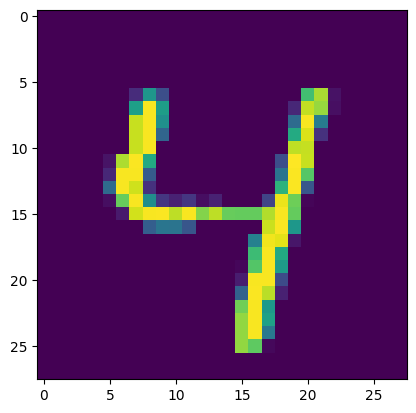

correct answer is  4
the prediction is  2


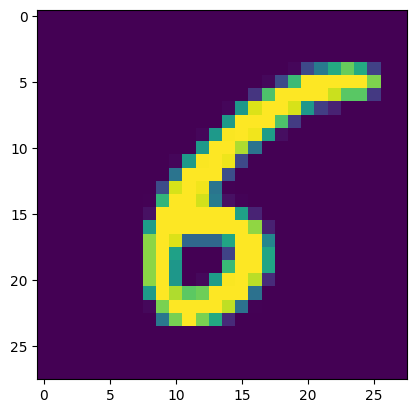

correct answer is  6
the prediction is  5


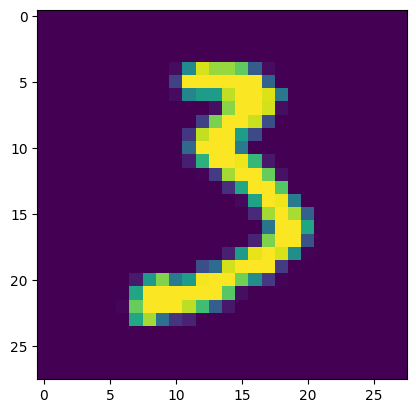

correct answer is  3
the prediction is  2


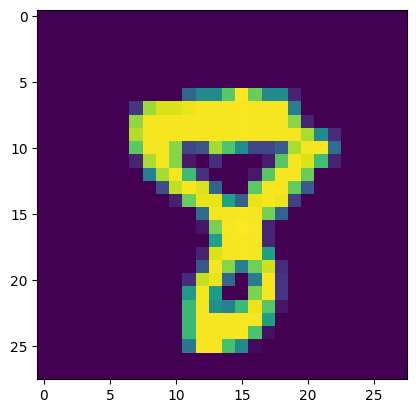

correct answer is  8
the prediction is  7


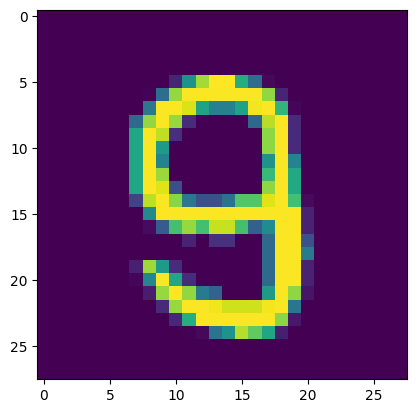

correct answer is  9
the prediction is  3


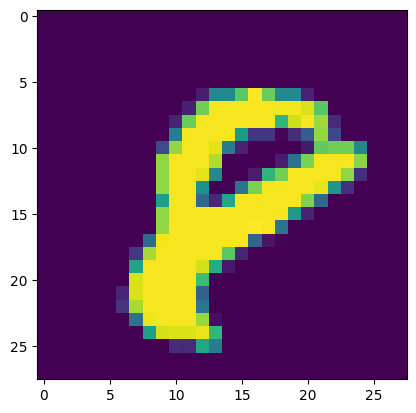

correct answer is  8
the prediction is  4


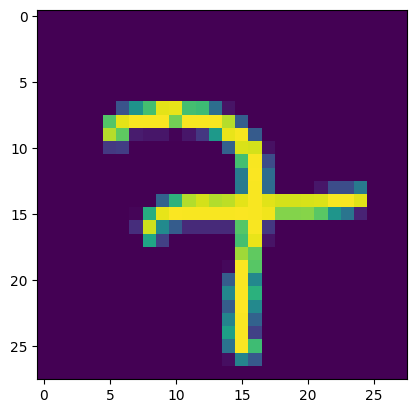

correct answer is  7
the prediction is  9


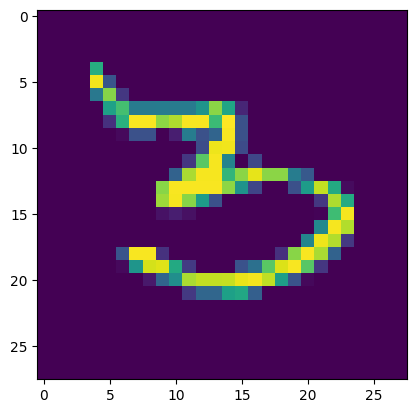

correct answer is  3
the prediction is  5


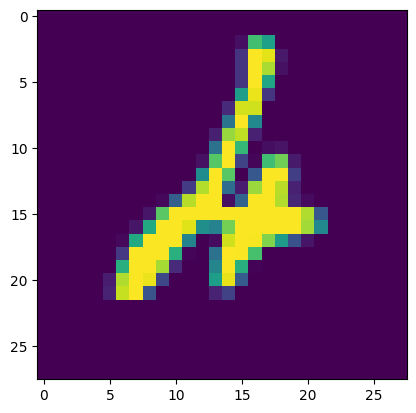

correct answer is  4
the prediction is  6


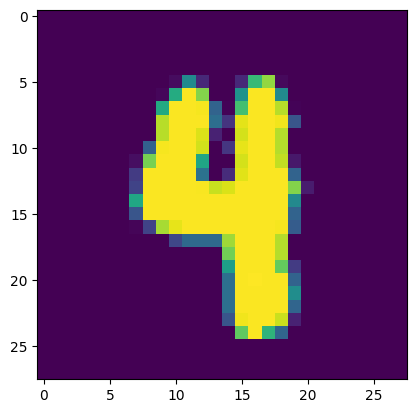

correct answer is  4
the prediction is  9


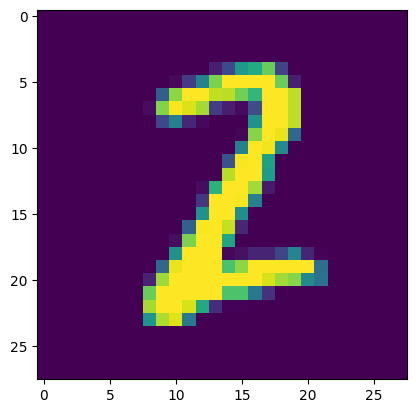

correct answer is  2
the prediction is  3


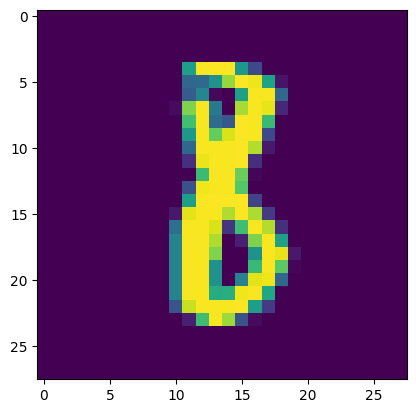

correct answer is  8
the prediction is  2


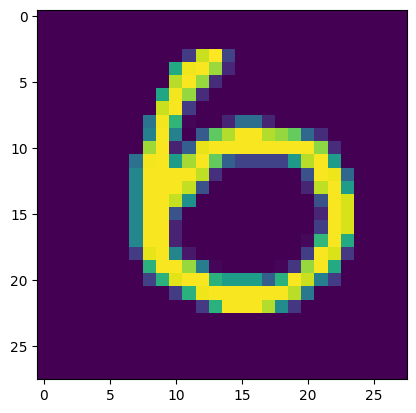

correct answer is  6
the prediction is  0


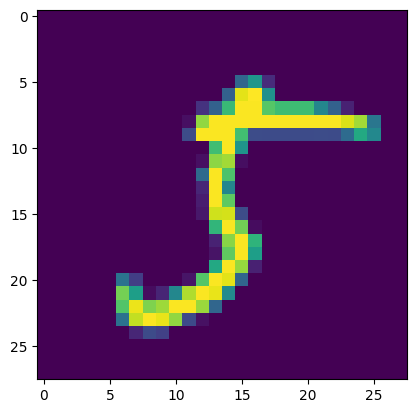

correct answer is  5
the prediction is  1


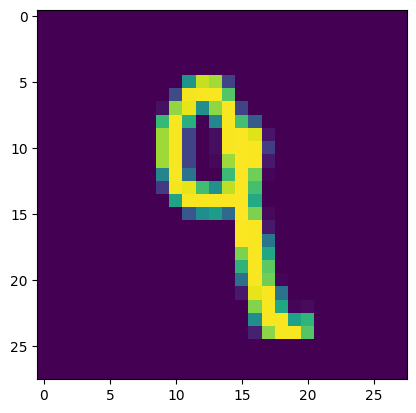

correct answer is  9
the prediction is  4


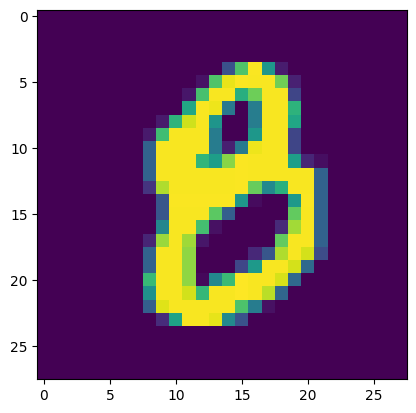

correct answer is  8
the prediction is  5


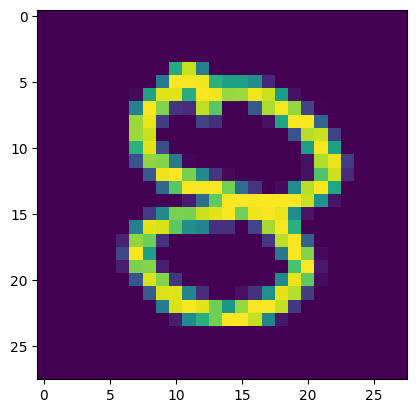

correct answer is  8
the prediction is  3


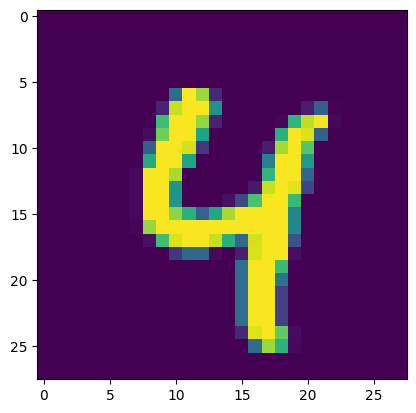

correct answer is  4
the prediction is  9


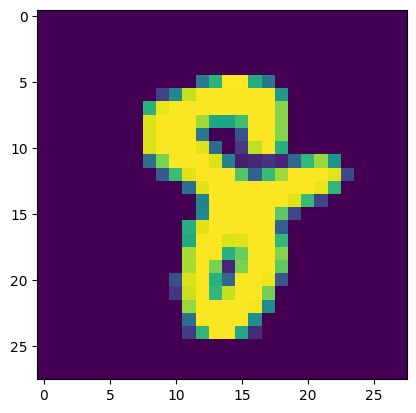

correct answer is  8
the prediction is  3


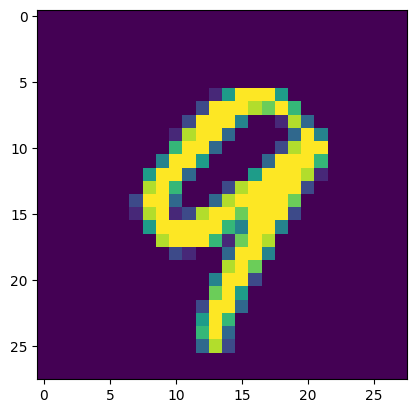

correct answer is  9
the prediction is  4


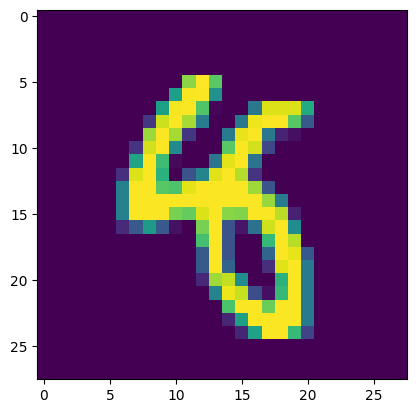

correct answer is  8
the prediction is  4


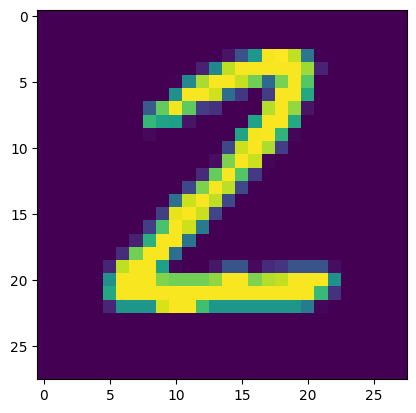

correct answer is  2
the prediction is  0


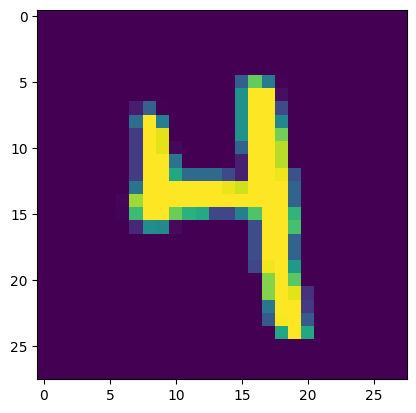

correct answer is  4
the prediction is  9


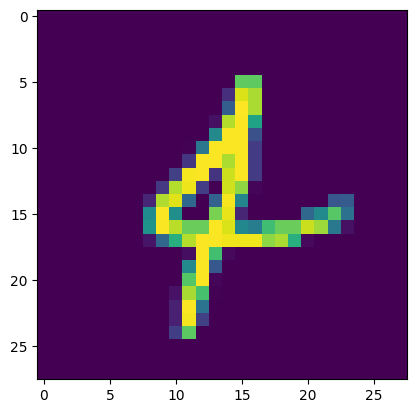

correct answer is  4
the prediction is  1


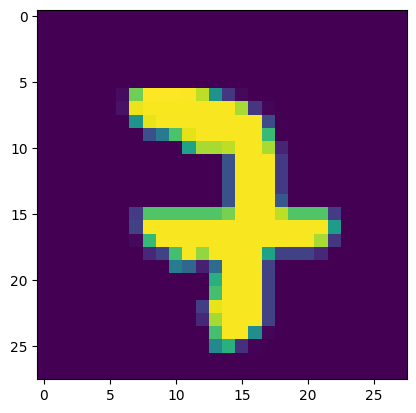

correct answer is  7
the prediction is  6


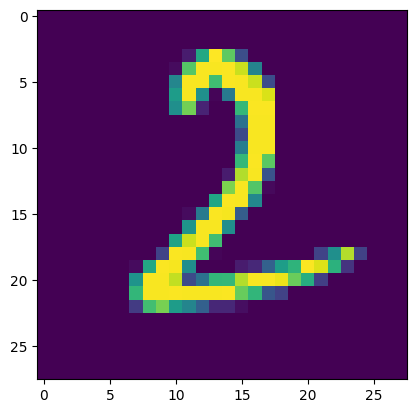

correct answer is  2
the prediction is  3


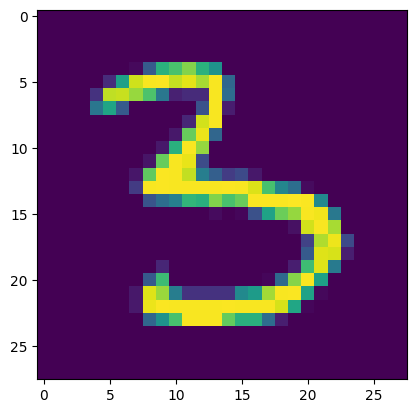

correct answer is  3
the prediction is  5


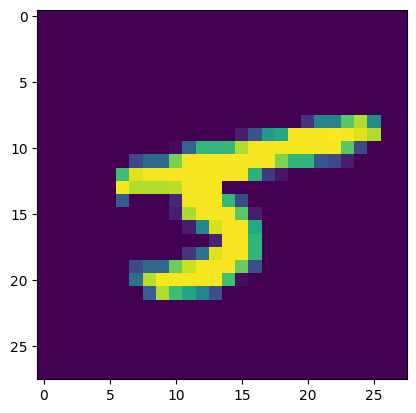

correct answer is  5
the prediction is  8


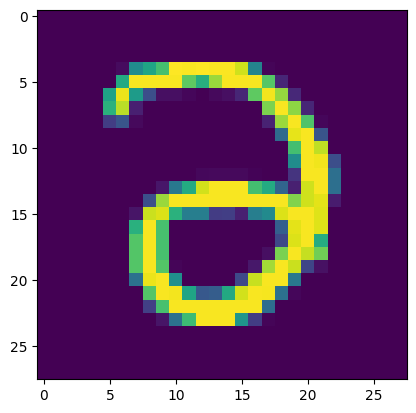

correct answer is  2
the prediction is  0


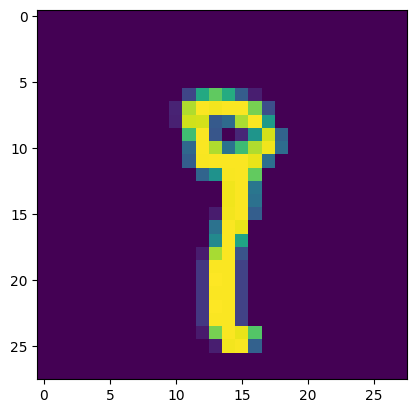

correct answer is  9
the prediction is  7


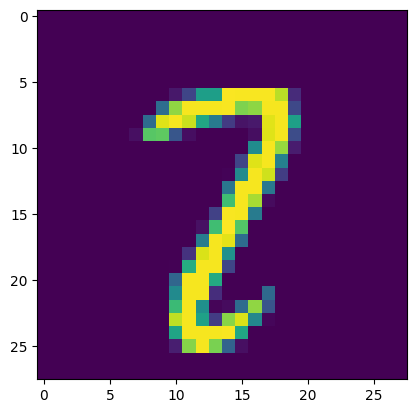

correct answer is  2
the prediction is  8


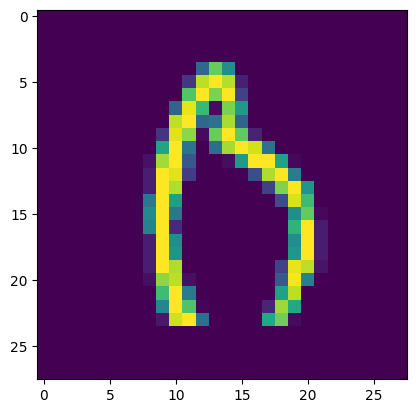

correct answer is  0
the prediction is  3


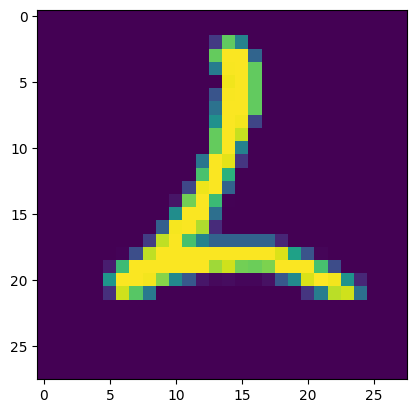

correct answer is  2
the prediction is  0


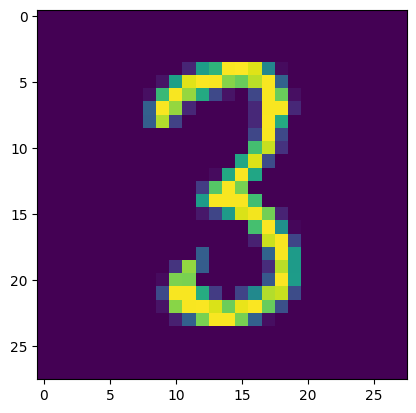

correct answer is  3
the prediction is  8


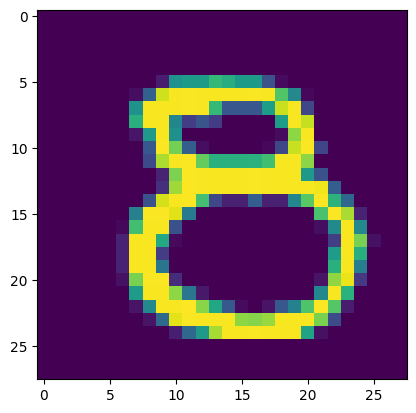

correct answer is  8
the prediction is  3


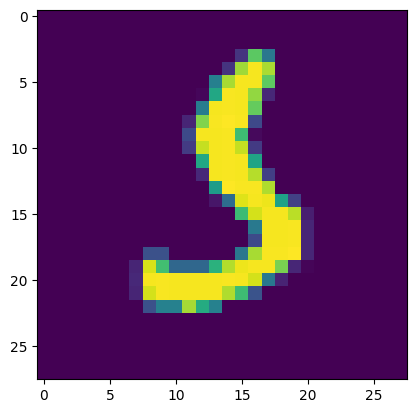

correct answer is  5
the prediction is  2


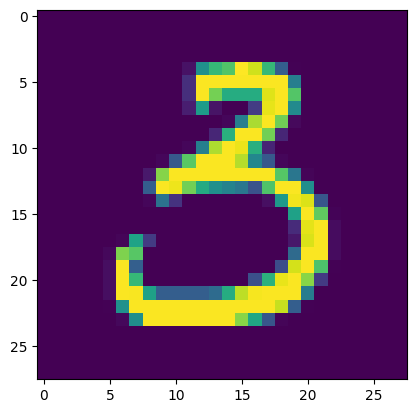

correct answer is  3
the prediction is  5


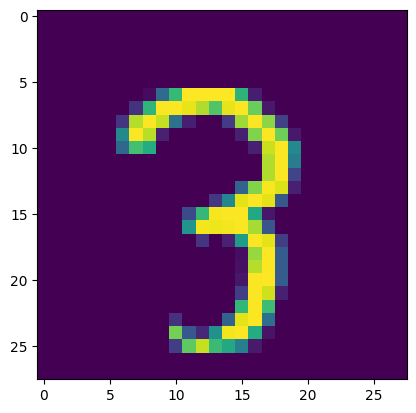

correct answer is  3
the prediction is  9


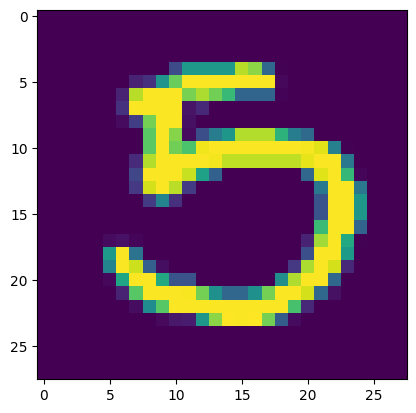

correct answer is  5
the prediction is  0


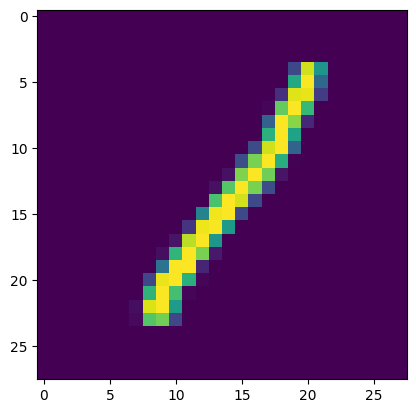

correct answer is  1
the prediction is  8


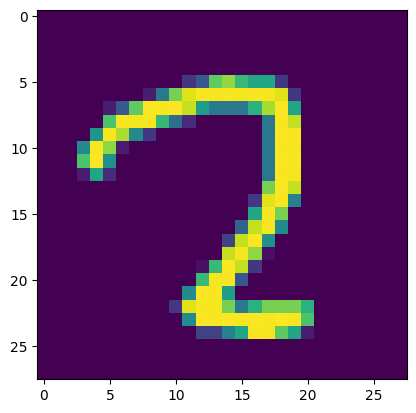

correct answer is  2
the prediction is  3


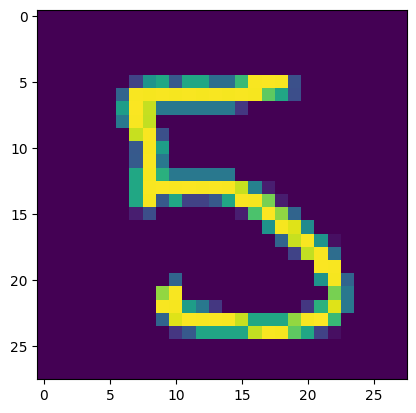

correct answer is  5
the prediction is  8


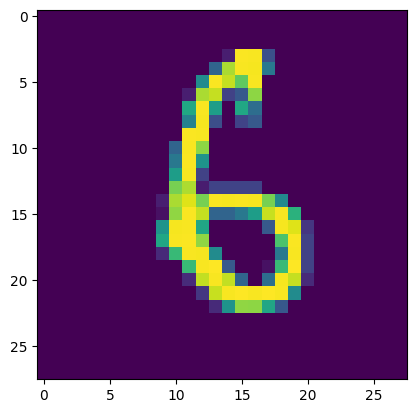

correct answer is  6
the prediction is  2


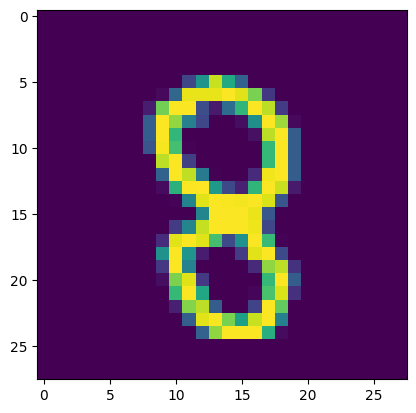

correct answer is  8
the prediction is  4


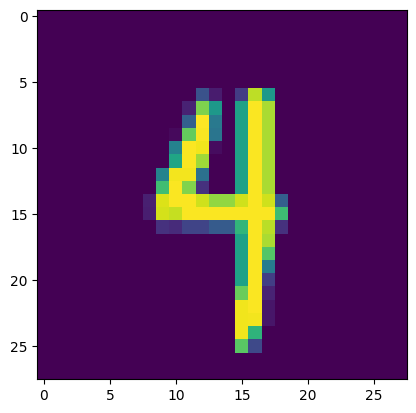

correct answer is  4
the prediction is  9


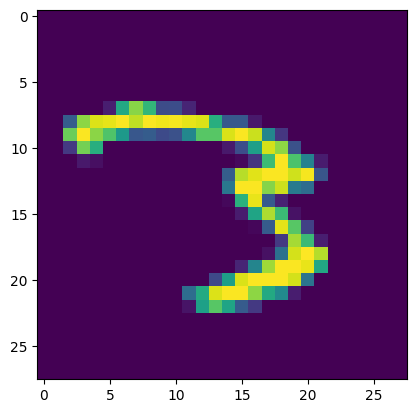

correct answer is  3
the prediction is  7


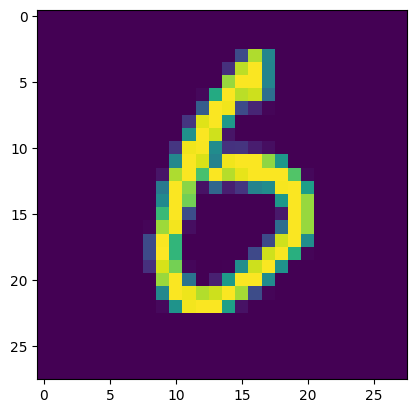

correct answer is  6
the prediction is  5


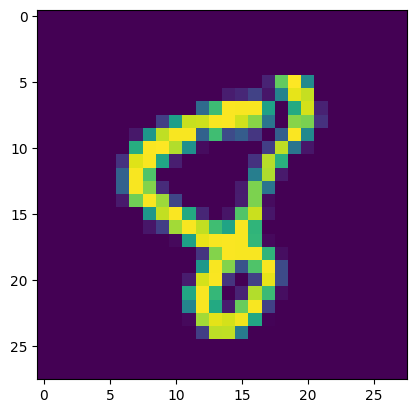

correct answer is  8
the prediction is  4


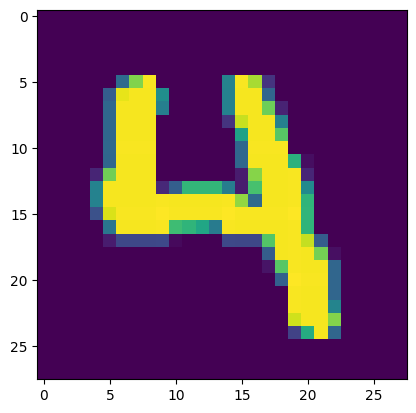

correct answer is  4
the prediction is  9


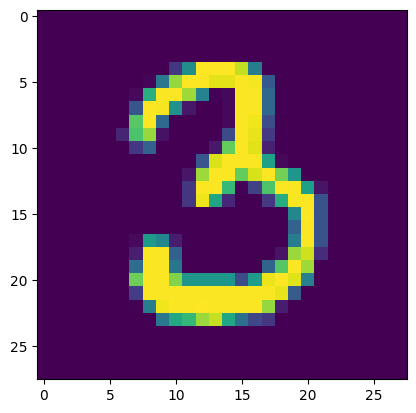

correct answer is  3
the prediction is  0


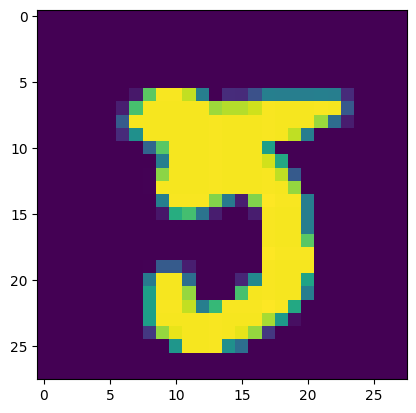

correct answer is  5
the prediction is  3


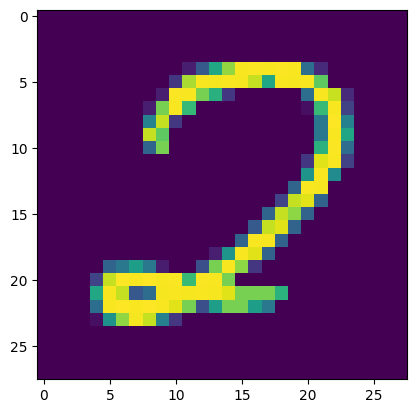

correct answer is  2
the prediction is  0


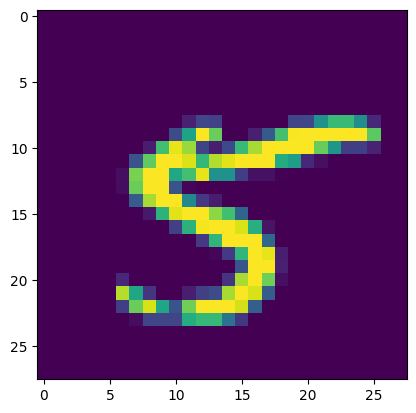

correct answer is  5
the prediction is  4


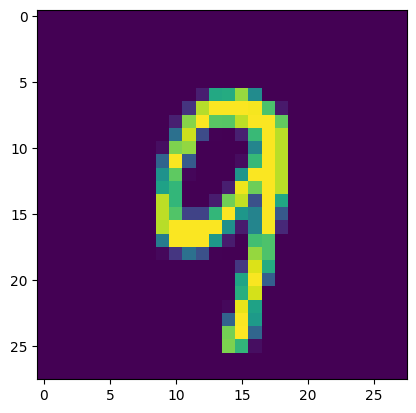

correct answer is  9
the prediction is  8


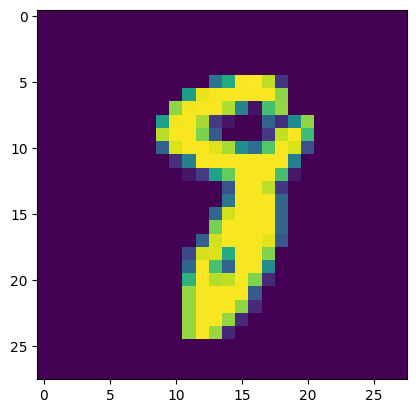

correct answer is  8
the prediction is  3


In [10]:
import matplotlib.pyplot as plt

def show_image(image, pred, label):
    img = image.reshape(28, 28)
    plt.imshow(img)
    plt.show()
    print("correct answer is ", label)
    print("the prediction is ", pred)

def show_misrecognized_images(images, y_pred, y_true, num=20):
    for i in range(images.size):
        if y_pred[i] != y_true[i]:
            show_image(images[i], y_pred[i], y_true[i])
            num = num - 1
            if num <= 0:
                break

#Show misrecognized images
show_misrecognized_images(x_test, y_test_pred, t_test, 100)

## 🤔 **Exercise 5.2.2**

Improve the performance of the neural network in hand-written number recognition with MNIST dataset by changing the hyperparameter to various values. Report the best accuracy and the hyperparameter values at the time. Describe your findings and observations from the results.


Accuracy(Test data):

Hyperparameters:
* The number of epoch: 10
* Minibatch-size: 2
* The number of layers in the network: 3
* The number of neurons in each hidden layer: 30
* learning rate: 0.3
* How did you set initial weights and biases:

Write other improvement points and/or discussions HERE:


In [11]:
from collections import OrderedDict

class Model4_1:
    def __init__(self, input_size, hidden_size, output_size):
        #initialize weights and biases
        W1 = np.random.randn(input_size, hidden_size)  #initialize weights with random value
        b1 = np.zeros(hidden_size)
        W2 = np.random.randn(hidden_size, hidden_size)  #initialize weights with random value
        b2 = np.zeros(hidden_size)
        W3 = np.random.randn(hidden_size, output_size)  #initialize weights with random value
        b3 = np.zeros(output_size)

        #neural network model definition
        self.layers = OrderedDict()
        self.layers['linear1'] = Linear(W1, b1)     # Linear layer
        self.layers['sigmoid1'] = Sigmoid()         # Sigmoid layer
        self.layers['linear2'] = Linear(W2, b2)     # Linear layer
        self.layers['sigmoid2'] = Sigmoid()         # Sigmoid layer
        self.layers['linear3'] = Linear(W3, b3)     # Linear layer
        self.layers['sigmoid3'] = Sigmoid()         # Sigmoid layer
        self.loss_layer = SoftmaxWithCrossEntropy() # Softmax with CrossEntropy layer

    def get_layers(self):
        return self.layers

    # forward calculation
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.loss_layer.forward(y, t)  # get Loss and return

    # backward calculation
    def backward(self):
        dL = self.loss_layer.backward() # Loss layer
        for layer in reversed(self.layers.values()):
            dL = layer.backward(dL)

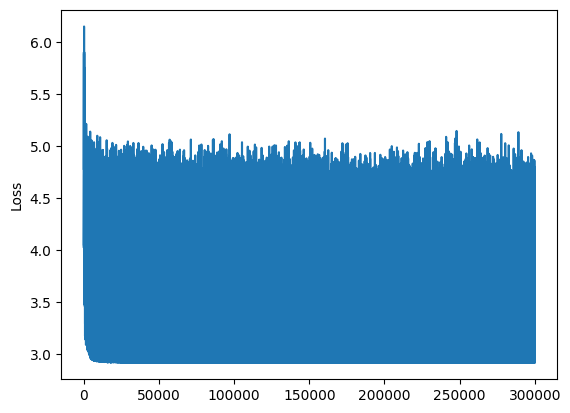

In [12]:
train_num = x_train.shape[0]
test_num = x_test.shape[0]

#model
input_size = x_train.shape[1]          # 784
output_size = t_train_onehot.shape[1]  # 10
hidden_size = 30                          # hyper parameter
net = Model4_1(input_size, hidden_size, output_size)
optimizer = SGD(learning_rate = 0.3)       # for update parameters

Epoch = 10 # the number of training
Minibatch_size = 2
Minibatch_num = int(train_num / Minibatch_size)
loss = []

#learning process
for i in range(Epoch):

    #Shuffled IDs for minibach
    idx = np.random.permutation(train_num)
    idx = np.reshape(idx, (-1, Minibatch_size))

    for i in range(Minibatch_num):
        #create minibatch datasets
        x = x_train[idx[i]]        # x is minibatch_size by 784 matrix
        t = t_train_onehot[idx[i]] # t is minibatch_size by 10 matrix

        l = net.loss(x, t)          #forward calculation
        net.backward()              # backward propagation
        optimizer.update(net.get_layers()) # update parameters
        loss.append(l)

# draw the loss graph
plt.plot(loss)
plt.ylabel("Loss")
plt.show()


In [13]:
# prediction (the output is the probability distribution)
y_train = net.predict(x_train)
y_test = net.predict(x_test)

# pred is the label of the output given the highest probability by the network
y_train_pred = np.argmax(y_train, axis=1)
y_test_pred = np.argmax(y_test, axis=1)

# evaluation
acc_train = accuracy(y_train_pred, t_train)
acc_test = accuracy(y_test_pred, t_test)
print("accuracy(train) = ", acc_train)
print("accuracy(test) = ", acc_test)

accuracy(train) =  0.8423333333333334
accuracy(test) =  0.8276


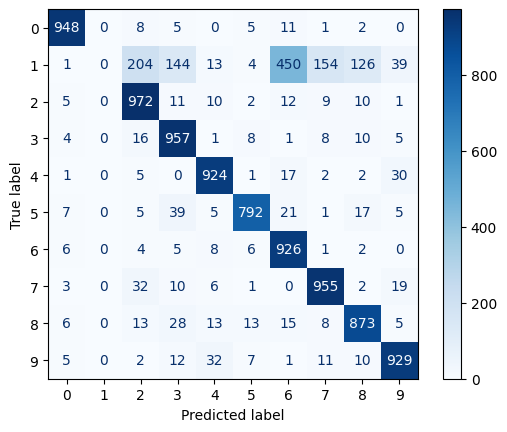

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = np.arange(0, 10, 1) # [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(y_pred=y_test_pred, y_true=t_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)

cmp.plot(cmap=plt.cm.Blues)

## 🤔 **Exercise 5.2.3**
Implement a neural network Model5 with 5 or more linear layers. You can freely set the number of neurons in the hidden layers. Train this model and check its accuracy.


In [15]:
from collections import OrderedDict

class Model5:
    def __init__(self, input_size, hidden_size, output_size):
        #initialize weights and biases
        W1 = np.random.randn(input_size, hidden_size)  #initialize weights with random value
        b1 = np.zeros(hidden_size)
        W2 = np.random.randn(hidden_size, hidden_size)  #initialize weights with random value
        b2 = np.zeros(hidden_size)
        W3 = np.random.randn(hidden_size, hidden_size)  #initialize weights with random value
        b3 = np.zeros(hidden_size)
        W4 = np.random.randn(hidden_size, hidden_size)  #initialize weights with random value
        b4 = np.zeros(hidden_size)
        W5 = np.random.randn(hidden_size, output_size)  #initialize weights with random value
        b5 = np.zeros(output_size)

        #neural network model definition
        self.layers = OrderedDict()
        self.layers['linear1'] = Linear(W1, b1)     # Linear layer
        self.layers['sigmoid1'] = Sigmoid()         # Sigmoid layer
        self.layers['linear2'] = Linear(W2, b2)     # Linear layer
        self.layers['sigmoid2'] = Sigmoid()         # Sigmoid layer
        self.layers['linear3'] = Linear(W3, b3)     # Linear layer
        self.layers['sigmoid3'] = Sigmoid()         # Sigmoid layer
        self.layers['linear4'] = Linear(W4, b4)     # Linear layer
        self.layers['sigmoid4'] = Sigmoid()         # Sigmoid layer
        self.layers['linear5'] = Linear(W5, b5)     # Linear layer
        self.layers['sigmoid5'] = Sigmoid()         # Sigmoid layer
        self.loss_layer = SoftmaxWithCrossEntropy() # Softmax with CrossEntropy layer

    def get_layers(self):
        return self.layers

    # forward calculation
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.loss_layer.forward(y, t)  # get Loss and return

    # backward calculation
    def backward(self):
        dL = self.loss_layer.backward() # Loss layer
        for layer in reversed(self.layers.values()):
            dL = layer.backward(dL)

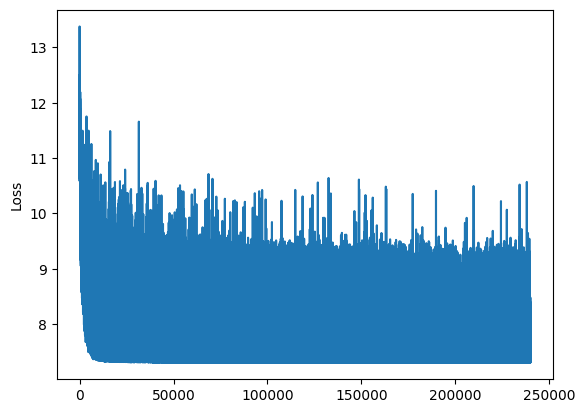

In [16]:
train_num = x_train.shape[0]
test_num = x_test.shape[0]

#model
input_size = x_train.shape[1]          # 784
output_size = t_train_onehot.shape[1]  # 10
hidden_size = 30                            # hyper parameter
net = Model5(input_size, hidden_size, output_size)
optimizer = SGD(learning_rate = 0.3)       # for update parameters

Epoch = 20 # the number of training
Minibatch_size = 5
Minibatch_num = int(train_num / Minibatch_size)
loss = []

#learning process
for i in range(Epoch):

    #Shuffled IDs for minibach
    idx = np.random.permutation(train_num)
    idx = np.reshape(idx, (-1, Minibatch_size))

    for i in range(Minibatch_num):
        #create minibatch datasets
        x = x_train[idx[i]]        # x is minibatch_size by 784 matrix
        t = t_train_onehot[idx[i]] # t is minibatch_size by 10 matrix

        l = net.loss(x, t)          #forward calculation
        net.backward()              # backward propagation
        optimizer.update(net.get_layers()) # update parameters
        loss.append(l)

# draw the loss graph
plt.plot(loss)
plt.ylabel("Loss")
plt.show()


In [17]:
# prediction (the output is the probability distribution)
y_train = net.predict(x_train)
y_test = net.predict(x_test)

# pred is the label of the output given the highest probability by the network
y_train_pred = np.argmax(y_train, axis=1)
y_test_pred = np.argmax(y_test, axis=1)

# evaluation
acc_train = accuracy(y_train_pred, t_train)
acc_test = accuracy(y_test_pred, t_test)
print("accuracy(train) = ", acc_train)
print("accuracy(test) = ", acc_test)

accuracy(train) =  0.9645833333333333
accuracy(test) =  0.9456


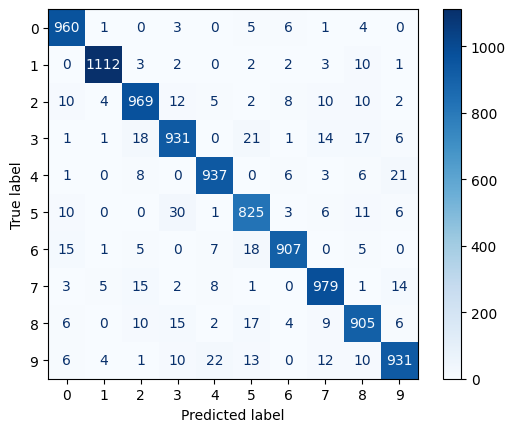

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = np.arange(0, 10, 1) # [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(y_pred=y_test_pred, y_true=t_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)

cmp.plot(cmap=plt.cm.Blues)

---
# **Recognition of Metropolia dataset**
---

## Load Metropolia Summer School dataset (mydata.zip) as numpy array

This dataset consists of a total of 3060 images written by 102 students who took this introduction to machine learning course during the three years from 2017 to 2019.

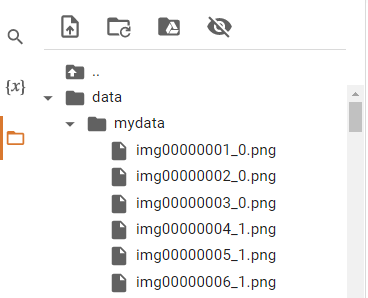

In [19]:
import os
import urllib.request
import zipfile

data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://github.com/a-ymst/IntroductionToMachineLearning/raw/main/images/mydata.zip"
save_path = os.path.join(data_dir, "mydata.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # load zip file
    zfile = zipfile.ZipFile(save_path)
    zfile.extractall(data_dir)  # extract zip file
    zfile.close()  # close zip file

    # delete zip file
    os.remove(save_path)

【Step2】Check and view the Metropolia dataset images

In [20]:
!ls data/mydata

img00000001_0.png  img00000766_5.png  img00001531_0.png  img00002296_6.png
img00000002_0.png  img00000767_5.png  img00001532_1.png  img00002297_6.png
img00000003_0.png  img00000768_5.png  img00001533_2.png  img00002298_6.png
img00000004_1.png  img00000769_6.png  img00001534_3.png  img00002299_7.png
img00000005_1.png  img00000770_6.png  img00001535_4.png  img00002300_7.png
img00000006_1.png  img00000771_6.png  img00001536_5.png  img00002301_7.png
img00000007_2.png  img00000772_7.png  img00001537_6.png  img00002302_8.png
img00000008_2.png  img00000773_7.png  img00001538_7.png  img00002303_8.png
img00000009_2.png  img00000774_7.png  img00001539_8.png  img00002304_8.png
img00000010_3.png  img00000775_8.png  img00001540_9.png  img00002305_9.png
img00000011_3.png  img00000776_8.png  img00001541_0.png  img00002306_9.png
img00000012_3.png  img00000777_8.png  img00001542_1.png  img00002307_9.png
img00000013_4.png  img00000778_9.png  img00001543_2.png  img00002308_0.png
img00000014_4.png  img000

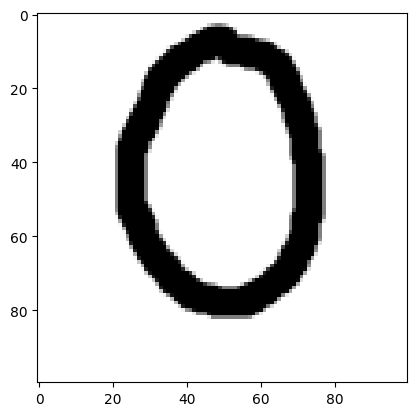

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("data/mydata/img00000001_0.png") # for example

plt.imshow(img)

【Step3】Load the Metropolia dataset to numpy.array. And make test_images, test_labels, train_images and train_labels.

In [22]:
from PIL import Image
import numpy as np
import os

dir = 'data/mydata/'

MUAS_images = np.empty((0,28*28))
MUAS_labels = np.empty((0), dtype=int)

for filename in os.listdir(dir):
        img = Image.open(dir + filename)
        img = img.convert('L')     # to gray scale
        img = img.resize((28, 28)) # resize to 28x28
        img_arr = 1 - (np.array(img) / 255)  # convert to numpy.array and normalization
        MUAS_images = np.vstack((MUAS_images, img_arr.reshape(1,28*28)))
        label = int(filename.split('.')[0].split('_')[1]) # extract label from filename
        MUAS_labels = np.append(MUAS_labels, label)


In [23]:
print("all_images.shape:", MUAS_images.shape)
print("all_labels.shape:", MUAS_labels.shape)

all_images.shape: (3060, 784)
all_labels.shape: (3060,)


In [24]:
#Shuffling of datasets and separation of training and testing data
train_num = 2500
idx = np.random.permutation(MUAS_images.shape[0])  # 3060
x_train = MUAS_images[idx[0:train_num]]
t_train = MUAS_labels[idx[0:train_num]]
x_test = MUAS_images[idx[train_num:]]
t_test = MUAS_labels[idx[train_num:]]

#one-hot encoding, out_size = 10
t_train_onehot = np.identity(10)[t_train]
t_test_onehot = np.identity(10)[t_test]

print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)

print("Successfully loaded the Metropolia Summer School dataset")

(2500, 784)
(560, 784)
(2500,)
(560,)
Successfully loaded the Metropolia Summer School dataset


After loading the Metropolia dataset, you can use the above training algorithm and validation program directly. Let's try!

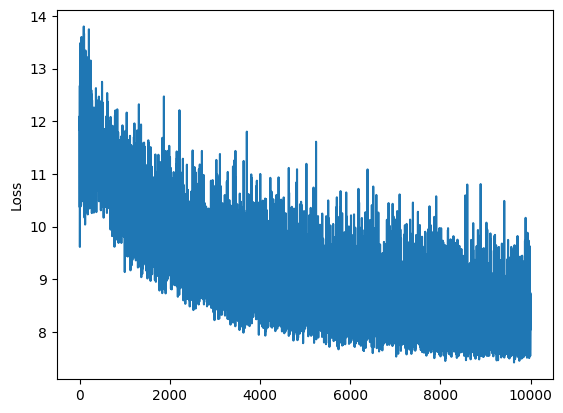

In [27]:
train_num = x_train.shape[0]
test_num = x_test.shape[0]

#model
input_size = x_train.shape[1]          # 784
output_size = t_train_onehot.shape[1]  # 10
hidden_size = 30                            # hyper parameter
net = Model5(input_size, hidden_size, output_size)
optimizer = SGD(learning_rate = 0.3)       # for update parameters

Epoch = 20 # the number of training
Minibatch_size = 5
Minibatch_num = int(train_num / Minibatch_size)
loss = []

#learning process
for i in range(Epoch):

    #Shuffled IDs for minibach
    idx = np.random.permutation(train_num)
    idx = np.reshape(idx, (-1, Minibatch_size))

    for i in range(Minibatch_num):
        #create minibatch datasets
        x = x_train[idx[i]]        # x is minibatch_size by 784 matrix
        t = t_train_onehot[idx[i]] # t is minibatch_size by 10 matrix

        l = net.loss(x, t)          #forward calculation
        net.backward()              # backward propagation
        optimizer.update(net.get_layers()) # update parameters
        loss.append(l)

# draw the loss graph
plt.plot(loss)
plt.ylabel("Loss")
plt.show()


In [28]:
# prediction (the output is the probability distribution)
y_train = net.predict(x_train)
y_test = net.predict(x_test)

# pred is the label of the output given the highest probability by the network
y_train_pred = np.argmax(y_train, axis=1)
y_test_pred = np.argmax(y_test, axis=1)

# evaluation
acc_train = accuracy(y_train_pred, t_train)
acc_test = accuracy(y_test_pred, t_test)
print("accuracy(train) = ", acc_train)
print("accuracy(test) = ", acc_test)

accuracy(train) =  0.812
accuracy(test) =  0.6285714285714286


## 🤔 **Exercise 5.2.4**


In most cases, the MNIST dataset will be recognized with better accuracy than the Metropolia dataset. What difference do you think there is between the two datasets (other than data size)?
Also, in order to recognize the Metropolia dataset with higher accuracy, it is possible to preprocess the images instead of improving the neural network. What kind of preprocessing do you think contributes to higher recognition accuracy?



Write your thoughts HERE.

To unify the letter size, set the middle point for each of the letters.
